# Network Intrusion in the Age of IoT 

![image1](https://camo.githubusercontent.com/56fb7c9e3129755320229df81eea6d1a4635d468/68747470733a2f2f63646e322e68756273706f742e6e65742f68756266732f3533323034352f706c6f746c792d776562696e61722d696f742d6e6574776f726b2d696e74727573696f6e2d393030783435302e6a7067)

This notebook was developed by [Aaron Kramer](https://github.com/aikramer2) with contributions from JR Gauthier at DataScience.com. 

## Introduction
With so many internet connected devices ranging from toasters, dishwashers, fridges to cars, network security of these devices is paramount.  It is crucial for manufacturers to understand the signature and identify attacks before they happen. 


## This Notebook


In this notebook, we will use [Plotly](https://plot.ly/) to create interactive charts and tables to explore the KDD Cup 99 dataset. This canonical dataset has been extensively used to train anomaly detection algorithms. It comes from about 4 Gb of compressed data of network traffic (7 weeks). It contains 5M connection records, each record comprises 41 features. The training dataset of 4.9M entries has each record labeled as either a **normal** connection or an **attack**. 

If the connection falls under the **attack** label, the dataset also provides the category of the attack. There are four categories: 

* **Denial of Service (DoS) Attack** : Overload the resource with requests. Denying other legitimate users of the service. We have seen this example not too long ago.

* **User to Root Attack (U2R)** : attacker gets access to a user account on the host, then gets root access

* **Remote to Local Attack (R2L)** : attacker has ability to send packets to a machine over the network but does not have an account on that machine. User exploits vulnerability to gain user access of that machine. 

* **Probing Attack** : attempt to gather info about a network of computers to exploit its security vulnerability. 


## References 

* [UCI KDD Cup 1999 Page](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
* [Tavallaee M., Bagheri, E., Lu, W., Ghorbani, A.A. 2009, "A detailed Analysis of the KDD Cup 99 Data Set", Proceedings of the IEEE Symposium on Computational Intelligence in Security and Defence Applications](http://ieeexplore.ieee.org/document/5356528/)

## General Module Imports

We will start the notebook by importing some general modules. These will be necessary to run the various tasks in the notebook. 

In [17]:
import os
import sys 
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from graphviz import Digraph
from sklearn.tree import DecisionTreeClassifier
from IPython.display import clear_output, Image
warnings.filterwarnings('ignore')

# We will import some utility functions that we wrote for this webinar. They are 
# stored in the utitlies/ folder in the plotly_webinar_utils.py module. 
sys.path.insert(0,'utilities/')
from plotly_webinar_utils import download, load_dataframe, visualize_tree
from core import load_config

## Plotly Module Imports

In the cell below, we list all the Plotly specific Module imports. We will use Plotly in an offline mode. In the offline mode, Plotly graphs are stored on your local system. In the online mode, the graphs are saved on a server. 

If you want to share these charts, you can publish them using an online Plotly account. 

In [30]:
# importing Plotly 

import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Plotly Version -- 2.5.1

We are using Plotly version 2.5.1. This notebook was run in a Python 3.6.2 kernel 

In [31]:
print("Plotly Version {} in a Python {}.{}.{} kernel".format(plotly.__version__,sys.version_info[0],
                                                             sys.version_info[1],
                                                             sys.version_info[2]))

Plotly Version 2.5.1 in a Python 3.6.2 kernel


# Download the KDD Cup 99 Dataset 

You will first need to download the KDD Cup 99 Dataset. The dataset is available [here](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is < 1Gb uncompressed. We will download a 10% sample of the full dataset. 

In [39]:
# We are downloading the data from http://kdd.ics.uci.edu/ 
# path is the local path to the datafile 
# attack_types is the mapping between attack and attack family 
# df_reader is either pandas (sample=True) or dask (sample=False)
path, attack_types, df_reader = download(sample=True)
df = load_dataframe(path, df_reader)

# We will map each attack to its parent family ('dos', 'u2r', 'r2l', 'probe'). 
# We use the mapping defined in this file: 
# http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types
df['attack_type'] = df['class'].map(attack_types)
df1 = df

# Here we are loading a yaml config file that includes all the 
# parameters we will be using later on to build the models. 
# the config file includes the list of all features, location of the 
# dataset, etc. 
# It's good practice to store these parameters for model and analysis 
# reproducibility. 
config = load_config()

# Exploration of the Dataset with Plotly  

In the cell below, we defined a function to display the dataframe using Plotly. We will use Plotly's ability to change the background color of different cells to highlight the entries corresponding to network attacks. 

We colored the anomalous entries in pink (there's only a couple in the first 1000 entries). Plotly makes it very easy to generate a table with a lot of entries. You can simply scroll down to see all entries. In the cell below, we show a subset of all columns. There are 41 features in this dataset. In the table below, we showcase a subset of these features. 

In [43]:
def event_data_table(df, nb_examples=1000): 
    """ This function will display a table of examples from the dataset.
    For entries that are classified as network intrusion (class != normal), 
    we use a different color (pink) to highlight that particular entry. 
    
    Args: 
    
    - nb_examples (int): Number of examples to show. Keep it less than a few 1K's. 
    
    Returns: 
    - Plotly figure 
    
    """
    # Number of instances to show: 
    nb_examples = nb_examples 
    df = df[0:nb_examples]
    color_vals = ['#F5F8FF'] * nb_examples
    
    # high data entries. We are using a different color for that entry: 
    # We recommend you try different combinations of colors. 
    ids = df.loc[df['class'] != 'normal'].index.values
    for i in ids: 
        color_vals[i] = 'pink'
    
    # We are using Plotly's graph object Table() to display a subset of the 
    # rows and columns.
    trace = go.Table(header=dict(values=['Duration','Protocol Type','Service', 
                                         'Flag', 'src_bytes', 'dst_bytes', 
                                         'class', 'attack_type'], 
                                 fill=dict(color='#C2D4FF'), align=['left'] * 5),
                     cells=dict(values=[df.duration, df.protocol_type, 
                                        df.service, df.flag, 
                                        df.src_bytes, df.dst_bytes, df['class'], 
                                        df['attack_type']], 
                                fill=dict(color=[color_vals]), 
                                align=['left']*5))
    data = [trace]
    fig = go.Figure(data=data)
    return fig 

# display the table 
fig = event_data_table(df1)
iplot(fig, filename='table')

# Frequency Count of Connection entries by Class (Normal vs Attack)  

The bar chart below shows that almost 60.3% of all entries in the dataset correspond to normal connections. 
Denial-of-Service (DoS) is the most frequent class of attacks with almost 40% of all connections. 

These 4 clases are attack are defined as : 

* `DOS`: denial-of-service, e.g. syn flood;
* `R2L`: unauthorized access from a remote machine, e.g. guessing password;
* `U2R`:  unauthorized access to local superuser (root) privileges, e.g., various buffer overflow  attacks;
* `probing`: surveillance and other probing, e.g., port scanning.

## Vertical Bar Chart

In [44]:
def chart_attack_counts(df1, chart_type='bar'): 
    """ Provides normalized event counts per connection class. 
    
    Args: 
    
    - df1 (DataFrame): Dataframe of connection entries 
    - chart_type (string): either 'bar' (vertical bars) or 'pie' (pie chart)
    
    Returns: 
    A Plotly Chart. 
    """
    
    # Normalize counts
    counts = df1['attack_type'].value_counts(normalize=True).sort_values()
    counts = counts*100 
    
    # Generate either a Plotly Bar() or Pie() object: 
    if chart_type == 'bar': 
        count_data = [go.Bar(
            x=list(counts.index),
            y=list(counts)
        )]
    elif chart_type == 'pie': 
        count_data = [go.Pie(labels=counts.index, values=counts.values)]
    else: 
        raise ValueError("Wrong chart type. Options are 'bar' or 'pie'")

    # Assign a layout to the chart: 
    layout = go.Layout(
            title='Frequency Distribution of Connections per Connection Class',
            xaxis=dict(title='Attack/Normal Type'), 
            yaxis=dict(title='Percentage (%)')
        )        
        
    # Generate and return a figure: 
    fig = go.Figure(data=count_data, layout=layout)
    return fig 

# Vertical Bar chart: 
fig = chart_attack_counts(df1)
iplot(fig, filename='basic-bar')

Let's look at the same data but this time with a pie chart: 

In [45]:
# Pie chart: 

fig = chart_attack_counts(df1, chart_type='pie')
iplot(fig, filename='basic-pie')

# Categories of Predictors/Features 

A description of each feature can be found on the [UCI KDD 99 page](http://kdd.ics.uci.edu/databases/kddcup99/task.html). In brief, the predictors are split in three categories : `basic`, `content`, and `traffic` features.  

* `basic` features : About individual TCP connections. Duration, number of bytes transfered, etc. 

* `content` features : Derived features based on domain knowledge and expertise of network intrusion. These features look for suspicious behavior,  such as the number of failed login attempt (see [KDD 99 page](http://kdd.ics.uci.edu/databases/kddcup99/task.html))

* `traffic` features : these are features computed within a two-second time window. These include things like the fraction of connections to the same service, etc. 

Below we show a split of the different features about these three categories: 

In [25]:
# Splitting the features among the "basic", "content" and "traffic" features 

d1 = df1[config['content_columns']].dtypes
d2 = df1[config['basic_columns']].dtypes
d3 = df1[config['traffic_columns']].dtypes
max_rows = max(map(len, [d1,d2,d3]))

cols = {}
cols1 = []

for feature, type_ in d1.iteritems():
    cols1.append(": ".join([feature, str(type_)]))

cols1 = cols1 + [""] * (max_rows - len(cols1))
    
cols['Content Attributes']=cols1
cols2 = []
for feature, type_ in d2.iteritems():
    cols2.append(": ".join([feature, str(type_)]))

cols2 = cols2 + [""] * (max_rows - len(cols2))
    
cols['Basic TCP Attributes']=cols2
cols3 = []
for feature, type_ in d3.iteritems():
    cols3.append(": ".join([feature, str(type_)]))
    
cols3 = cols3 + [""] * (max_rows - len(cols3))    
cols['Traffic Attributes']=cols3
pd.DataFrame.from_dict(cols)

,Basic TCP Attributes,Content Attributes,Traffic Attributes
0,duration: int64,hot: int64,count: int64
1,src_bytes: int64,num_failed_logins: int64,serror_rate: float64
2,dst_bytes: int64,logged_in: int64,rerror_rate: float64
3,land: int64,num_compromised: int64,same_srv_rate: float64
4,wrong_fragment: int64,root_shell: int64,diff_srv_rate: float64
5,urgent: int64,su_attempted: int64,srv_count: int64
6,,num_root: int64,srv_serror_rate: float64
7,,num_file_creations: int64,srv_rerror_rate: float64
8,,num_shells: int64,srv_diff_host_rate: float64
9,,num_access_files: int64,


# Plotly Heatmap : Response vs Traffic Predictors 

In the heatmap below, we show the relationship between the different classes of connections and the typical percentile of each predictor value that is found for that particular class of connections. In other words, we are tryting to identify if different classes of attacks have outlier values for any of these predictors. That will inform the model building step of our work. 

In [26]:
def mycut(series, bins, labels=None):
    """ COMPLETE THIS 
    
    """
    groups = {}
    names = {}
    percentiles = pd.Series(np.percentile(series, [i * 5 for i in range(21)]))
    unique_percentile_vals = np.unique(percentiles)
    data = series.apply(lambda x: unique_percentile_vals[np.argmin(abs(unique_percentile_vals-x))])
    for val in unique_percentile_vals:
        index = percentiles[percentiles==val].index.values
        m0, m1 = min(index) * 5, max(index) * 5
        m_ = (m0 + m1) / 2
        groups[val] = m_
        names[m_] = '{0} to {1} percentile'.format(m0, m1)
    data = data.map(groups)
    return data, names

In [27]:
traffic_medians = {}

columns_of_interest = config['traffic_columns']

for i, feature in enumerate(columns_of_interest):
    scaled_data, names = mycut(df1[feature], 20)
    df1['aux'] = scaled_data
    medians = df1.groupby('attack_type')['aux'].median()
    traffic_medians[feature] = medians

df1 = df1.drop('aux', 1)


medians = pd.DataFrame(traffic_medians).T.unstack().reset_index()
medians.columns = ['attack_type', 'network attribute', 'typical percentile']

In [28]:
data = [go.Heatmap(z=medians['typical percentile']
                   , y=medians['attack_type']
                   , x=medians['network attribute']
                   , xaxis='hello'            
                  )]

layout = go.Layout(title='Typical Percentile of Traffic Volume by Attack Type',
                   xaxis={'title':"Connection Attributes"},
                   yaxis={'title':"Activity Type"},)


figure = go.Figure(data=data, layout=layout)
iplot(figure)

## A Simple Model Based on Traffic Predictors Only 

Below we show how a simple decision tree classifier can classify connection data into the different classes of attacks/normal traffic: 

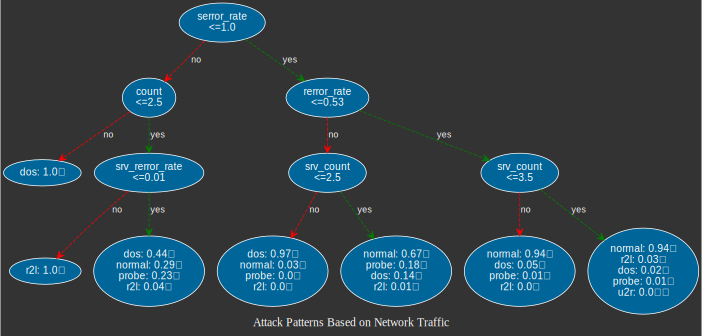

In [29]:
# let's use only traffic predictors to build a simple classifier model 

# predictors: 
X = df1[columns_of_interest].values

# target values (attacks/normal): 
y = df1['attack_type'].values

# let's train a shallow decision tree classifier. Only traffic predictors. 
estimator = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
estimator.fit(X, y)

# Decision Tree visualization: 
graph = visualize_tree(estimator, X, y, 
                       feature_names = columns_of_interest, 
                       title='Attack Patterns Based on Network Traffic')
graph

The graph above gives you a good sense for how a classifier may split the data to make effective decisions. Let's take a simple example. If you want to isolate `dos` events, one way to do it based on the heatmap above would be to select events with high `serror_rate` and  `count` values. That's exactly what the classifier is doing. 

It's a good sanity check that the classifier is working! Note that we limited the classifier to a depth of 3. 

You can take this notebook and build similar simple classifiers with the other classes of predictors, namely `basic` and `content` predictors. 